In [177]:
from math import pi
import itertools as itt

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from src.root_path import config_path

from src.data.rasters import load_site_formated_raster
from src.metrics.consolidated_dprimes import single_cell_dprimes
from src.metrics.significance import _significance

from src.visualization.fancy_plots import squarefy, quantified_dprime

### Plotting parameters

In [178]:
plt.style.use(['default', config_path / 'presentation.mplstyle'])

# list of sequences, manually prepended zeros
sequences = np.asarray([[0,1,3,2,4,4],
                        [0,3,4,1,1,2],
                        [0,4,2,3,3,1],
                        [0,2,2,1,4,3]])

n_samps = 100
colors = ['blue', 'orange', 'green', 'purple', 'brown']
dummy_wave = np.sin(np.linspace(0,pi*4,n_samps)) * 0.5 # todo, pull some real example waves??
waves = [np.zeros(n_samps)] + [dummy_wave, ] * 5 + [np.zeros(n_samps)]
vertical_offset = 1
prb_idx = 3 - 1# selected probe. the -1 is to acount for 0 not being used
ctx_pair = [0,1] # pair of contexts to compare and exemplify d'
cellid = 'ARM021b-36-8'


# rasters
site_raster, goodcellse = load_site_formated_raster(cellid[:7], part='all', smoothing_window=50)
eg_raster = site_raster[:, goodcellse.index(cellid),:, prb_idx, :]


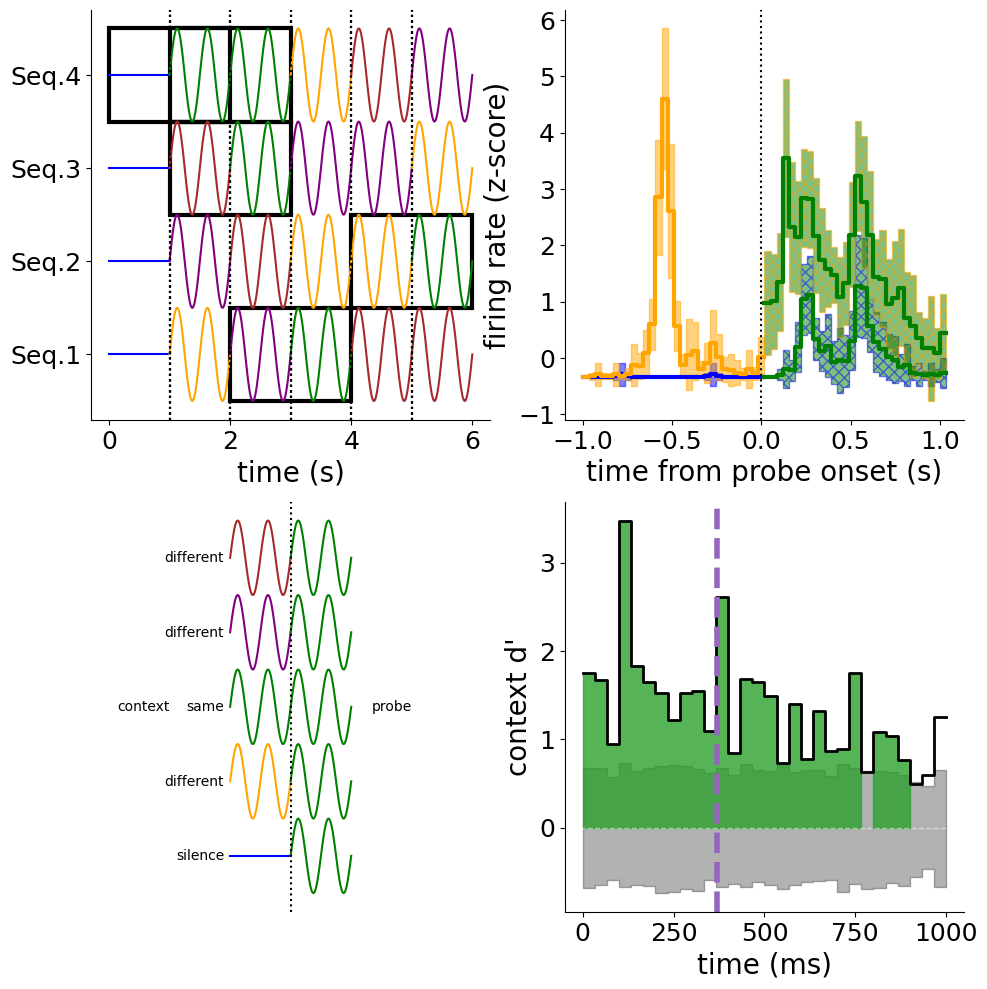

In [179]:

##############################################################################
########## figure and subplots locations #####################################
##############################################################################

fig, axes = plt.subplot_mosaic([['seq', 'ctx'   ],
                                ['prb', 'dprime']], figsize=[10,10])

##############################################################################
# sound sequences plus selected examples #####################################
##############################################################################

ax = axes['seq']
for ss, seq in enumerate(sequences):
    for ww, wave_idx in enumerate(seq):
        # wave form plots
        x = np.linspace(0,1,n_samps) + ww
        y = waves[wave_idx] + ss * vertical_offset
        color = colors[wave_idx]
        ax.plot(x, y, color)

        # vertical lines for clear separation of sounds
        if ww > 0:
            ax.axvline(ww, color='black', linestyle=':')

        # add rectangle to point at exaample
        if wave_idx == prb_idx:
            rect_x = ww - 1
            rect_y = ss * vertical_offset - 0.5
            rect_w, rect_h = 2, 1 # 2 seconds widht, 2*norm wave
            rect = patches.Rectangle((rect_x, rect_y), rect_w, rect_h,
                                     linewidth=3, edgecolor='black', facecolor='none')
            ax.add_patch(rect)

ax.set_xlabel('time (s)')
ax.set_yticks(range(4))
ax.set_yticklabels([f'Seq.{i+1}' for i in range(4)])

##############################################################################
# stimulus selected examples and context type clasification ##################
##############################################################################
hor_off = 3
ax = axes['prb']
ax.sharex(axes['seq'])
for ww, (wave, color) in enumerate(zip(waves, colors)):
    # context
    x = np.linspace(-1, 0, n_samps) + hor_off # sum to offset to center, insline with sequences
    y = wave + ww * vertical_offset
    ax.plot(x, y, color)
    # probe
    x = np.linspace(0, 1, n_samps) + hor_off
    y = waves[prb_idx] + ww * vertical_offset
    ax.plot(x, y, colors[prb_idx])

    # context type text
    if ww == 0:
        type_text = 'silence'
    elif ww == prb_idx:
        type_text = 'same'
    else:
        type_text = 'different'
    ax.text(-1.1 + hor_off, ww * vertical_offset, type_text, ha='right', va='center')

ax.axvline(0+hor_off, color='black', linestyle=':')

# context and probe text
ax.text(-2+hor_off, 2, 'context', ha='right', va='center')
ax.text(2+hor_off, 2, 'probe', ha='right', va='center')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


##############################################################################
# example response to pair of contexts########################################
##############################################################################

ax = axes['ctx']
for cxt_idx in ctx_pair:
    nsamps = eg_raster.shape[-1]
    time = np.linspace(-1, 1, nsamps)
    mean_resp = np.mean(eg_raster[:,cxt_idx, :], axis=0)
    std_resp = np.std(eg_raster[:,cxt_idx, :],axis=0)

    halfs = [np.s_[:int(nsamps/2)], np.s_[int(nsamps/2):]]
    part_color = [colors[cxt_idx], colors[prb_idx]]


    for nn, (half, color) in enumerate(zip(halfs, part_color)):

        x, y = squarefy(time[half], mean_resp[half])
        _, ystd = squarefy(time[half], std_resp[half])

        ax.plot(x, y, color=color, linewidth=3)
        if nn == 0:
            ax.fill_between(x, y-ystd, y+ystd, color=color, alpha=0.5)
        else:
            ax.fill_between(x, y-ystd, y+ystd, facecolor=color, edgecolor=part_color[0], hatch='xxx', alpha=0.5)

ax.axvline(0, color='black', linestyle=':')

ax.set_xlabel('time from probe onset (s)')
ax.set_ylabel('firing rate (z-score)')

##############################################################################
######## dprime and significant metrics from the example context pair ########
##############################################################################

meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None,
        'stim_type': 'permutations',
        'alpha':0.05}

dprime, shuff_dprime_quantiles, goodcells, var_capt = single_cell_dprimes(cellid[:7], contexts='all', probes='all', meta=meta)
significance, confidence_interval = _significance(dprime, shuff_dprime_quantiles,
                                                  multiple_comparisons_axis=[3], consecutive=3, alpha=meta['alpha'])
cell_idx = goodcells.index(cellid) if len(cellid) > 7 else 0
pair_idx = [f'{t0}_{t1}' for t0, t1 in itt.combinations(range(dprime.shape[2]), 2)].index(f'{ctx_pair[0]}_{ctx_pair[1]}')

ax = axes['dprime']
# this specific example is flipped,
fig, ax = quantified_dprime(dprime[cell_idx, pair_idx, prb_idx, :] * -1,
                            confidence_interval[:, cell_idx, pair_idx, prb_idx, :] * -1,
                            significance[cell_idx, pair_idx, prb_idx, :],
                            raster_fs=meta['raster_fs'], ax=ax, show_legend=False)

_ = ax.set_ylabel("context d'")
plt.show()

In [180]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from webcolors import name_to_rgb

## import relevant data

## full figure configuration

In [185]:
# simple plot layout and other figurewide configurations

fig = make_subplots(rows=4,cols=1, vertical_spacing=0.05, horizontal_spacing=0.05)

# figure size in inches at different PPIs

ppi = 300 # high quality print standard (do i need this if I do postprocecing in vectors)
ppi = 96 # www standard
ppi = 92.5 # house monitor

width = 3 # in inches
heigh =  width * 4
_ = fig.update_layout(template='simple_white',
                      margin=dict(l=10, r=10, t=10, b=10),
                      width=round(ppi*width), height=round(ppi*heigh),
                      showlegend=False)

### sound sequences plus selected examples

In [186]:
#
row, col = 1, 1 # 1 indexing fuck my life!
for ss, seq in enumerate(sequences):
    for ww, wave_idx in enumerate(seq):
        # wave form plots
        x = np.linspace(0,1,n_samps) + ww
        y = waves[wave_idx] + ss * vertical_offset
        color = colors[wave_idx]

        _ = fig.add_trace(go.Scatter(x=x, y=y, line_color=color, mode='lines'),
                          row=row, col=col)

        # vertical lines for clear separation of sounds
        if ww > 0:
            _ = fig.add_vline(x=ww, line_width=2, line_color='black', line_dash='dot',
                              row=row, col=col)

        # add rectangle to point at exaample
        if wave_idx == prb_idx:
            x0 = ww - 1
            y0 = ss * vertical_offset - 0.5
            xd, yd = 2, 1 # 2 seconds widht, 2*norm wave
            x = [x0, x0, x0+xd, x0+xd, x0]
            y = [y0, y0+yd, y0+yd, y0, y0]
            _ = fig.add_trace(go.Scatter(x=x, y=y, line_color='black', mode='lines'),
                            row=row, col=col)

# Update xaxis properties, includding x padding to avoid trace clipping
_ = fig.update_xaxes(title_text='time (s)', title_standoff=0, range=[-0.1,6.1] ,
                     row=row, col=col)
_ = fig.update_yaxes(tickmode='array', tickvals=list(range(4)), ticktext=[f'Seq.{i+1}' for i in range(4)],
                     row=row, col=col)

### selected stimuli examples and transition type clasification

In [187]:
row, col = 2, 1

hor_off = 3
ax = axes['prb']
ax.sharex(axes['seq'])
for ww, (wave, color) in enumerate(zip(waves, colors)):
    # context
    x = np.linspace(-1, 0, n_samps) + hor_off # sum to offset to center, insline with sequences
    y = wave + ww * vertical_offset
    _ = fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color=color),
                      row=row, col=col)
    # ax.plot(x, y, color)

    # probe
    x = np.linspace(0, 1, n_samps) + hor_off
    y = waves[prb_idx] + ww * vertical_offset
    _ = fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color=colors[prb_idx]),
                      row=row, col=col)
    # ax.plot(x, y, colors[prb_idx])

    # context type text
    if ww == 0:
        type_text = 'silence'
    elif ww == prb_idx:
        type_text = 'same'
    else:
        type_text = 'different'

    _ = fig.add_trace(go.Scatter(x=[-1.1 + hor_off], y=[ww * vertical_offset],
                                 mode='text', text=[type_text],
                                 textposition='middle left', textfont_size=15),
                      row=row, col=col)

# ax.axvline(0+hor_off, color='black', linestyle=':')
_ = fig.add_vline(x=hor_off, line_width=2, line_color='black', line_dash='dot', opacity=1,
                  row=row, col=col)
# context and probe text
_ = fig.add_trace(go.Scatter(x=[hor_off-0.2, hor_off+0.2],
                             y=[-1, -1],
                             mode='text', text=['<b>Context</b>', '<b>Probe</b>'],
                             textposition=['middle left', 'middle right'], textfont_size=18),
                  row=row, col=col)

_ = fig.update_layout(xaxis2=dict(visible=False, showline=False, matches='x'),
                      yaxis2=dict(visible=False, showline=False))

### example pair of PSTHs

In [188]:
row, col = 3, 1
# row, col = 'all', 'all'
# fig = make_subplots(rows=1,cols=1)

for cxt_idx in ctx_pair:
    nsamps = eg_raster.shape[-1]
    time = np.linspace(-1, 1, nsamps)
    mean_resp = np.mean(eg_raster[:,cxt_idx, :], axis=0)
    std_resp = np.std(eg_raster[:,cxt_idx, :],axis=0)

    halfs = [np.s_[:int(nsamps/2)], np.s_[int(nsamps/2):]]
    part_color = [colors[cxt_idx], colors[prb_idx]]


    for nn, (half, color) in enumerate(zip(halfs, part_color)):

        x, y = squarefy(time[half], mean_resp[half])
        _, ystd = squarefy(time[half], std_resp[half])

        # off set half a bin to the left
        halfbin = np.mean(np.diff(time))/2
        x -= halfbin
        y -= halfbin
        ystd -= halfbin

        if nn == 0:
            # ax.fill_between(x, y-ystd, y+ystd, color=color, alpha=0.5)
            _ = fig.add_trace(go.Scatter(x=x, y=y+ystd, mode='lines', line_color=color, line_width=1),
                              row=row, col=col)
            _ = fig.add_trace(go.Scatter(x=x, y=y-ystd, mode='lines', line_color=color, line_width=1,
                                         fill='tonexty'),
                              row=row, col=col)

        else:
            # to set a transparent fillcolor changes the 'rgb(x,y,z)' into 'rgba(x,y,z,a)'
            rgb = name_to_rgb(part_color[0]) # tupple
            fill_opacity = 0.5
            rgba = f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, {fill_opacity})'

            _ = fig.add_trace(go.Scatter(x=x, y=y+ystd, mode='lines', line_color=color, line_width=1),
                  row=row, col=col)
            _ = fig.add_trace(go.Scatter(x=x, y=y-ystd, mode='lines', line_color=color, line_width=1,
                                         fill='tonexty', fillcolor=rgba),
                              row=row, col=col)

        # set the mean lines second so they lie on top of the colored areas
        _ = fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color=color, line_width=3),
                          row=row, col=col)

_ = fig.add_vline(x=0, line_width=2, line_color='black', line_dash='dot', opacity=1,
                  row=row, col=col)

_ = fig.update_xaxes(title_text='time from probe onset (s)', title_standoff=0,
                     row=row, col=col)
_ = fig.update_yaxes(title_text='firing rate (z-score)', title_standoff=0,
                     row=row, col=col)

# fig.show()

### example quantified dprime

In [184]:

signif_mask = significance>0
t =  np.linspace(0, dprime.shape[-1]/raster_fs, dprime.shape[-1],endpoint=False) * 1000

# calculates center of mass and integral
significant_abs_mass_center = np.sum(np.abs(dprime[signif_mask]) * t[signif_mask]) / np.sum(np.abs(dprime[signif_mask]))
significant_abs_sum = np.sum(np.abs(dprime[signif_mask])) * np.mean(np.diff(t))

if ax is None:
    fig, ax = plt.subplots()
else:
    fig = ax.figure


# plots dprime plus fit
tt, mmdd = squarefy(t, dprime)
ax.plot(tt, mmdd, color='black', linewidth=2)
_, CCII = squarefy(t, confidence_interval.T)
ax.fill_between(tt, CCII[:,0], CCII[:,1], color='black', alpha=0.3)
_ = ax.axhline(0, color='white', linewidth=1, linestyle='--', alpha=0.5)

p1 = ax.fill_between(tt, 0, mmdd, where=np.repeat(signif_mask,2), color='C2', alpha=0.8,
                       label=f"integral\n{significant_abs_sum:.2f} d'*ms")

p2 = ax.axvline(significant_abs_mass_center, color='C4', linewidth=4, linestyle='--',
             label=f'center of mass\n{significant_abs_mass_center:.2f} ms')

if show_legend:
    ax.legend(handles=[p1, p2], loc='upper right')
# plt.legend(handles=[p1, p2], bbox_to_anchor=(1.05, 1), loc='upper left')

# formats axis, legend and so on.
ax.set_ylabel(f"contextual effects discriminability (d')")
ax.set_xlabel('time (ms)')
